In [25]:
import numpy as np

def dsdt(t,s):
  mass,I_z = 1,1
  alpha,beta = 0,0
  x,x_dot,y,y_dot,theta,theta_dot,thrust,thrust_dot,moment,moment_dot = s
  return [
    x_dot,
    thrust*np.cos(theta)/mass,
    thrust*np.sin(theta)/mass,
    theta_dot,
    moment/I_z,
    thrust_dot,
    alpha,
    moment_dot,
    beta
  ]

Optimal T: 0.6315360482853106
Optimal M: 0.2519834117859906
(6, 100)


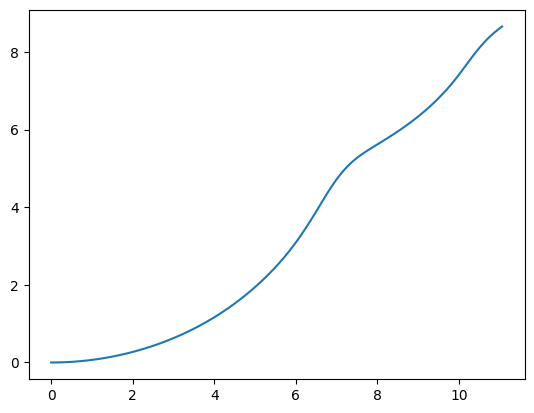

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# Define the system of ODEs
def odes(t, y, T, M):
  x, y, theta, x_dot, y_dot, theta_dot = y
  m = 1  # Mass
  Iz = 1  # Moment of inertia

  x_ddot = T * np.cos(theta) / m
  y_ddot = T * np.sin(theta) / m
  theta_ddot = M / Iz

  return [x_dot, y_dot, theta_dot, x_ddot, y_ddot, theta_ddot]

# Define the objective function to minimize
def objective(params):
  T, M = params

  # Initial and final conditions
  y0 = [0, 0, 0, 0, 0, 0]  # [x, y, theta, x_dot, y_dot, theta_dot] at t=0
  time = np.linspace(0,10,100)

  # Solve the ODEs
  sol = solve_ivp(odes, [min(time),max(time)] , y0, args=(T, M), t_eval=time)

  # Calculate the final position
  xf, yf, thetaf, _, _, _ = sol.y[:, -1]

  # Calculate the cost (distance from the final position to the target)
  cost = (xf - 10)**2 + (yf - 10)**2

  return cost

# Bounds for T and M
bounds = [(0, 1), (-1, 1)]

# Initial guess
x0 = [0.5, 0.5]

# Minimize the objective function
result = minimize(objective, x0, bounds=bounds)

# Optimal values for T and M
optimal_T, optimal_M = result.x

print("Optimal T:", optimal_T)
print("Optimal M:", optimal_M)

time = np.linspace(0,10,100)
intial_conditions = [0, 0, 0, 0, 0, 0]  # [x, y, theta, x_dot, y_dot, theta_dot] at t=0
T = optimal_T
M = optimal_M
optimized_solution = solve_ivp(odes, [0,max(time)],y0=intial_conditions,args=(T,M),t_eval=time)
print((optimized_solution.y).shape)
plt.plot(optimized_solution.y[0],optimized_solution.y[1])

In [27]:
import tensorflow as tf
from keras.models import Sequential
from tqdm.notebook import tqdm
from keras.layers import Dense
from numpy import pi

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

def createTraj():
  fhat = Sequential()
  fhat.add(Dense(50, activation="sigmoid", input_dim=1))
  fhat.add(Dense(1))
  return fhat

x = createTraj()
y = createTraj()
theta = createTraj()
thrust = createTraj()
moment = createTraj()

Num GPUs Available:  0
[]


In [30]:
initial_time = 0
final_time = 1
number_of_points = 20
normalize_time = tf.cast(tf.linspace(initial_time,final_time,number_of_points),dtype=tf.float32)
def errors(t):
  with tf.GradientTape(persistent=True) as tape1:
    tape1.watch(t)
    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch(t)
      X = x(t)
      Y = y(t)
      TH = theta(t)
      THRUST = thrust(t)
      MOMENT = moment(t)
    Xd = tape2.gradient(X, t)
    Yd = tape2.gradient(Y, t)

  # Compute the derivatives
  Xdd = tape1.gradient(Xd, t)
  Ydd = tape1.gradient(Yd, t)
  # THd = tape1.gradient(TH, t)

  # Error in dynamics
  e_xddot = tf.reduce_sum((tf.reshape(Xdd, shape=(number_of_points, 1)) - Xdd * tf.cos(TH)) ** 2)
  e_yddot = tf.reduce_sum((tf.reshape(Ydd, shape=(number_of_points, 1)) - Ydd * tf.sin(TH)) ** 2)

  # Error in initial condition
  x0 = 0
  y0 = 0
  th_0 = 0
  x_dot_0 = 0
  y_dot_0 = 0
  th_dot_0 = 0
  thrust_0 = 0
  moment_0 = 0
  eIC = (X[0] - x0) ** 2 + (Y[0] - y0) ** 2 + (TH[0]) ** 2 + (THRUST[0]-thrust_0 )** 2 + (MOMENT[0] - moment_0)**2 # start from (x0,y0) at rest and pointing east

  # Error in final condition
  xf = 1
  yf = 1
  th_f = 0
  x_dot_f = 0
  y_dot_f = 0
  th_dot_0 = 0
  thrust_f = 0
  moment_f = 0
  eFC = (X[-1] - xf) ** 2 + (Y[-1] - yf) ** 2 + (TH[-1] - np.pi) ** 2 + (THRUST[-1]- thrust_f)** 2 + (MOMENT[-1]-moment_f)**2

  return e_xddot + e_yddot + 10 * eIC + 10 * eFC

In [31]:
run_counter = 0
while errors(normalize_time) >= 0.001:
    nIter = 400
    run_counter += 1
    if run_counter == 10:
        print('Failed to converge')
        break
    if errors(normalize_time) <= 1:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    elif errors(normalize_time) <= 0.5:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
    elif errors(normalize_time) <= 0.1:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
    elif errors(normalize_time) <= 0.01:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
    else:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
    for i in tqdm(range(nIter),desc=f"Training run {run_counter}"):
        with tf.GradientTape(persistent=True) as tape:
            e = errors(normalize_time)
        if e <= 0.001:
            print('Finish Training')
            break
    
        # Update parameters in x
        grads = tape.gradient(e, x.trainable_variables)
        optimizer.apply_gradients(zip(grads, x.trainable_variables))

        # Update parameters in y
        grads = tape.gradient(e, y.trainable_variables)
        optimizer.apply_gradients(zip(grads, y.trainable_variables))

        # Update parameters in th
        grads = tape.gradient(e, theta.trainable_variables)
        optimizer.apply_gradients(zip(grads, theta.trainable_variables))

        # Update parameters in thrust
        grads = tape.gradient(e, thrust.trainable_variables)
        optimizer.apply_gradients(zip(grads, thrust.trainable_variables))

        # Update parameters in moment
        grads = tape.gradient(e, moment.trainable_variables)
        optimizer.apply_gradients(zip(grads, moment.trainable_variables))

    print(f"Last error: {round(float(errors(normalize_time)[0]),4)}")

Training run 1:   0%|          | 0/400 [00:00<?, ?it/s]

: 